V 12.  Fixed orientation

V 13.  Added 2019 (first stage test)

V 14. Added Voronoi areas

V 16.  Handling of unbounded Voronoi regions

This notebook is an attempt at reproducing with Python what [Michael Lopez did in R](https://www.kaggle.com/statsbymichaellopez/nfl-tracking-initial-wrangling-voronoi-areas).  Some of the code is borrowed or modified from [Rob Mula's](https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position) and [SRK's](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-nfl) great notebooks.  

I've included the test data collected via this simple notebook: https://www.kaggle.com/cpmpml/save-test

One initial but tricky issue when working with NFL player tracking data is that sometimes players are moving left to right, and other times they are moving right to left. One recommended technique for working with this data is to standardize play directions, so that the offensive team is always moving in the same direction. This idea is particularly important for this year's Big Data Bowl event on Kaggle, where many participants will look to engineer football-specific features. 

To start off, let's read in the data, creating a dummy variable for plays moving left to right (`ToLeft`), as well as an indicator for whether or not the player is the ball carrier (`IsBallCarrier`). 

Next, we add in a few tweaks to account for different factors between the `PossessionTeam`/`FieldPosition` variables and the `HomeTeamAbbr`/`VisitorTeamAbbr`.

Last, but not least, we shift direction so that cosine of direction maps to the X axis, and sine of direction maps to the Y axis.  We change both the unit from degrees to radians, but also the direction origin and the way direction increases. We'll see later that this matches what we could see on screen during the play.

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import datetime, tqdm
from kaggle.competitions import nflrush

import math

from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
train = pd.read_csv("../input/nfl-big-data-bowl-2020/train.csv", low_memory=False)
test = pd.read_csv('../input/dsbowl2019-test/test.csv', low_memory=False)

In [3]:
set(train.columns) - set(test.columns)

{'Yards'}

In [4]:
test['Yards'] = np.NaN
train = pd.concat((train, test[train.columns]), axis=0)

In [5]:
train['ToLeft'] = train.PlayDirection == "left"
train['IsBallCarrier'] = train.NflId == train.NflIdRusher

train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

train['Dir_rad'] = np.mod(90 - train.Dir, 360) * math.pi/180.0
    

Let's see how plays are rendered here.  I use 2 plays for which I have videos. 

(<Figure size 1728x911.52 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0cab9ab278>)

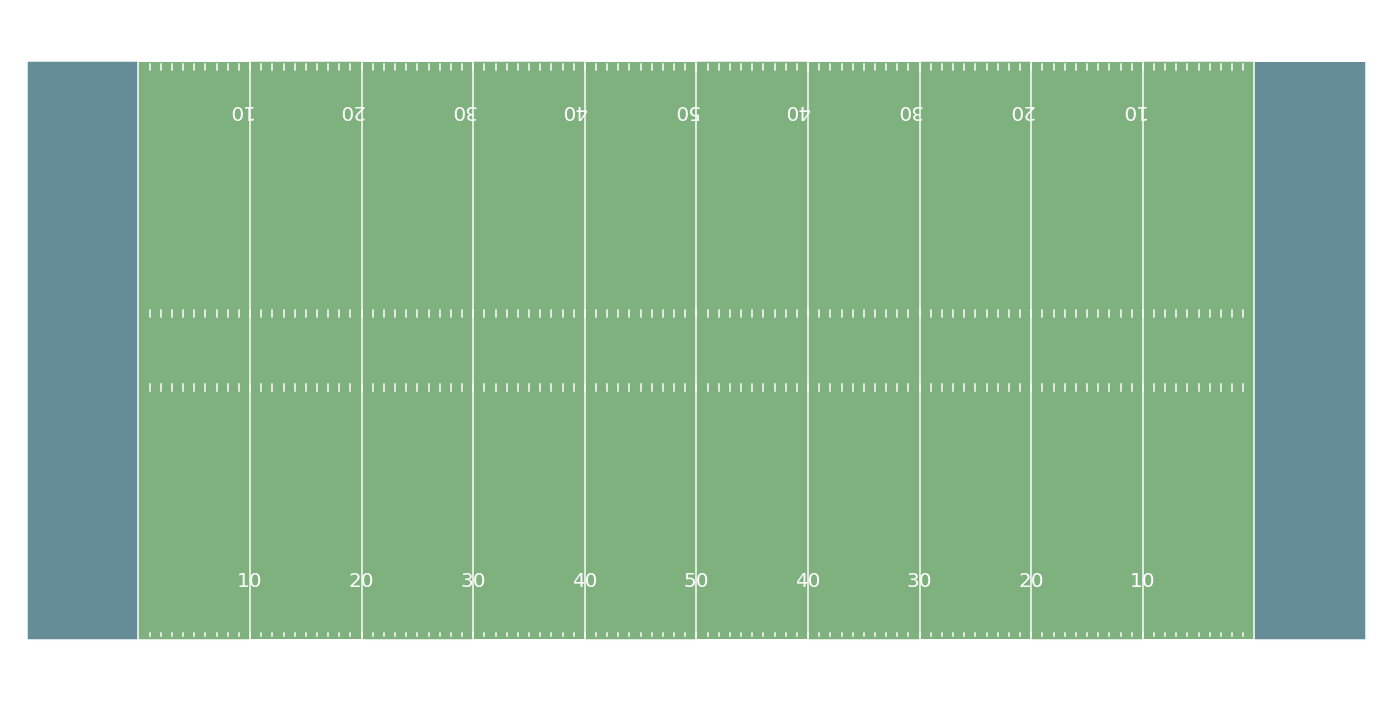

In [6]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax
create_football_field()

In [7]:
def get_dx_dy(radian_angle, dist):
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, train=train):
    df = train[train.PlayId == play_id]
    fig, ax = create_football_field()
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir_rad"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

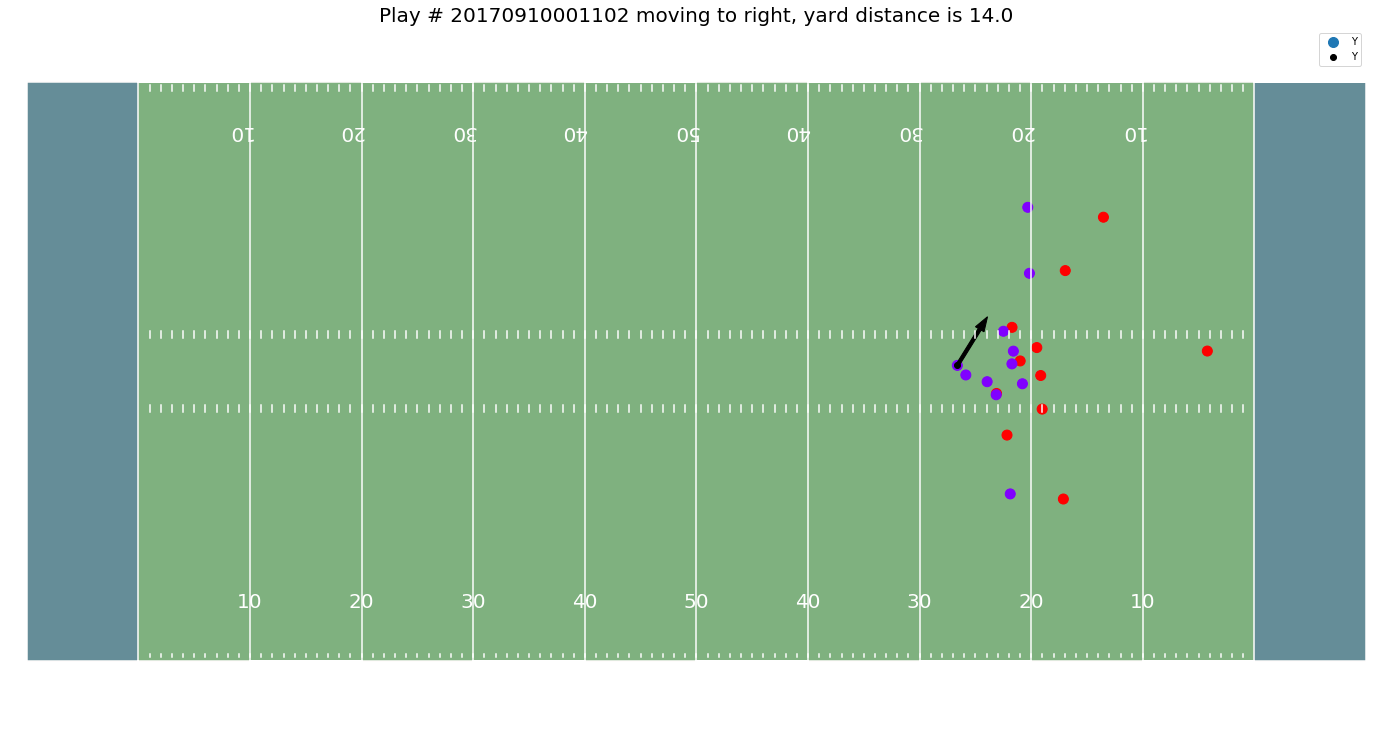

In [8]:
show_play(20170910001102)

On screen, we see the following play

![](https://media.giphy.com/media/ckZnw8Nm0bwbRm99fl/giphy.gif)

At the moment of the handoff (when a ball carrier gets the ball), Tolbert is moving as much to the left as he is moving forward. This matches to how the arrow is displayed by our code.

Let's look at a second play.

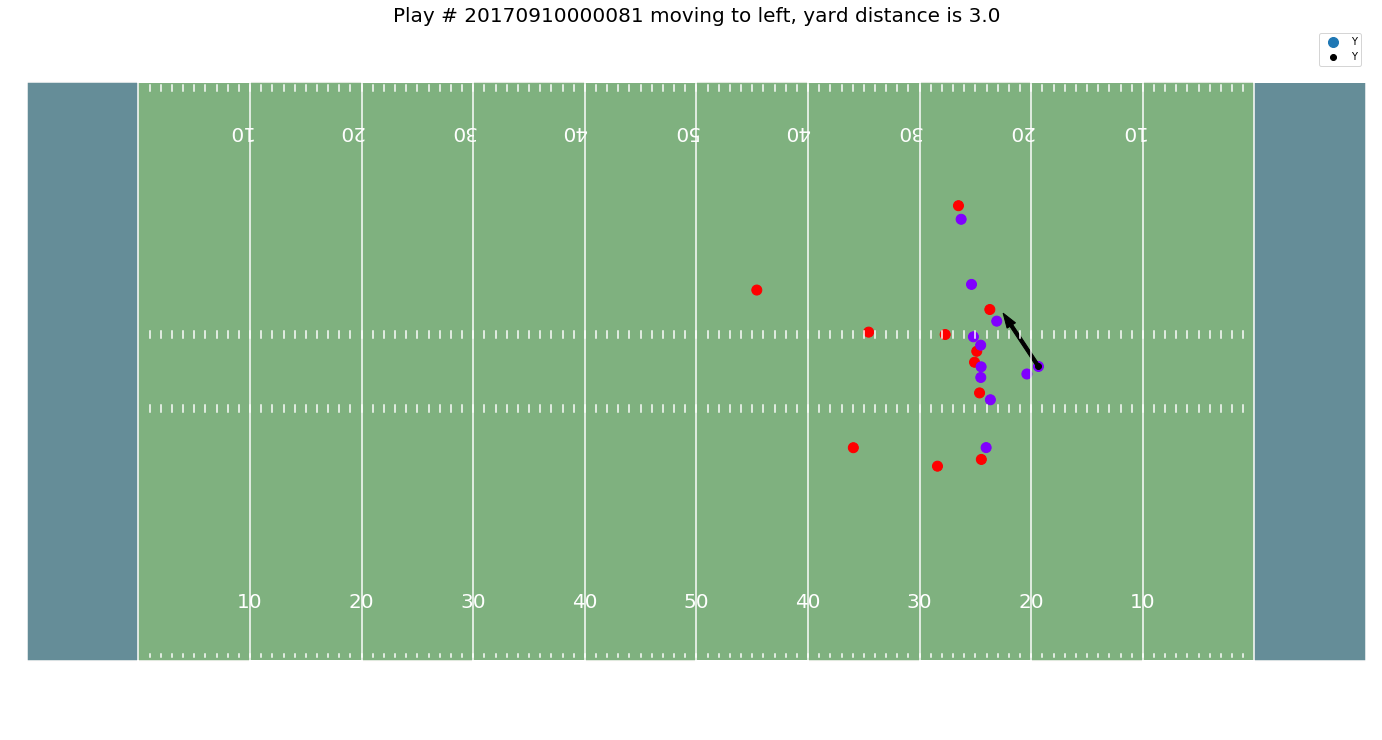

In [9]:
show_play(20170910000081)

In this play, Tolbert's teammate LeSean McCoy takes the ball and moves to his right.  Again, this mathces our arrow (fortunately).  This proves that the way I shift direction is the right way.

![](https://media.giphy.com/media/mBwPxbGLGNjpLSpenx/giphy.gif)

Even though the same team has the ball in the same game as the play above, the offense is now moving right to left (`PlayDirection == "left")`. 


It's really hard to tell which team is on offense friom the data! Even though the ball carrier is highlighted in black, the inconsistency from one play to the next is less than ideal. Sometimes the away team is on offense, other times the home team is on offense. And they're both potentially moving left or moving right. 

Our ultimate goal will be to ensure that the offensive team (`PossessionTeam`) is moving left to right, even if in the raw data, the offense is moving right to left. 

The following set of code will get us there.

In [10]:
train['TeamOnOffense'] = "home"
train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
train['YardLine_std'] = 100 - train.YardLine
train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
train['X_std'] = train.X
train.loc[train.ToLeft, 'X_std'] = 120 - train.loc[train.ToLeft, 'X'] 
train['Y_std'] = train.Y
train.loc[train.ToLeft, 'Y_std'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
#train['Orientation_std'] = -90 + train.Orientation
#train.loc[train.ToLeft, 'Orientation_std'] = np.mod(180 + train.loc[train.ToLeft, 'Orientation_std'], 360)
train['Dir_std'] = train.Dir_rad
train.loc[train.ToLeft, 'Dir_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Dir_rad'], 2*np.pi)


Taking the above code, we'll play the standardized `X` and `Y` variables, similar to what we did above. We also created the `YardLine_std` variable -- in football language, this is the line of scrimmage. More importantly, we've ensured the `YardLine_std`, unlike `YardLine`, treats each side of the field differently. For example, if `YardLine == 25`, that could mean the possession team has 75 yards to go for a touchdown, or it could mean it has 25 yards to go for a touchdown. 


In [11]:
def show_play_std(play_id, train=train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X_std, df.Y_std, df.Dir_std, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

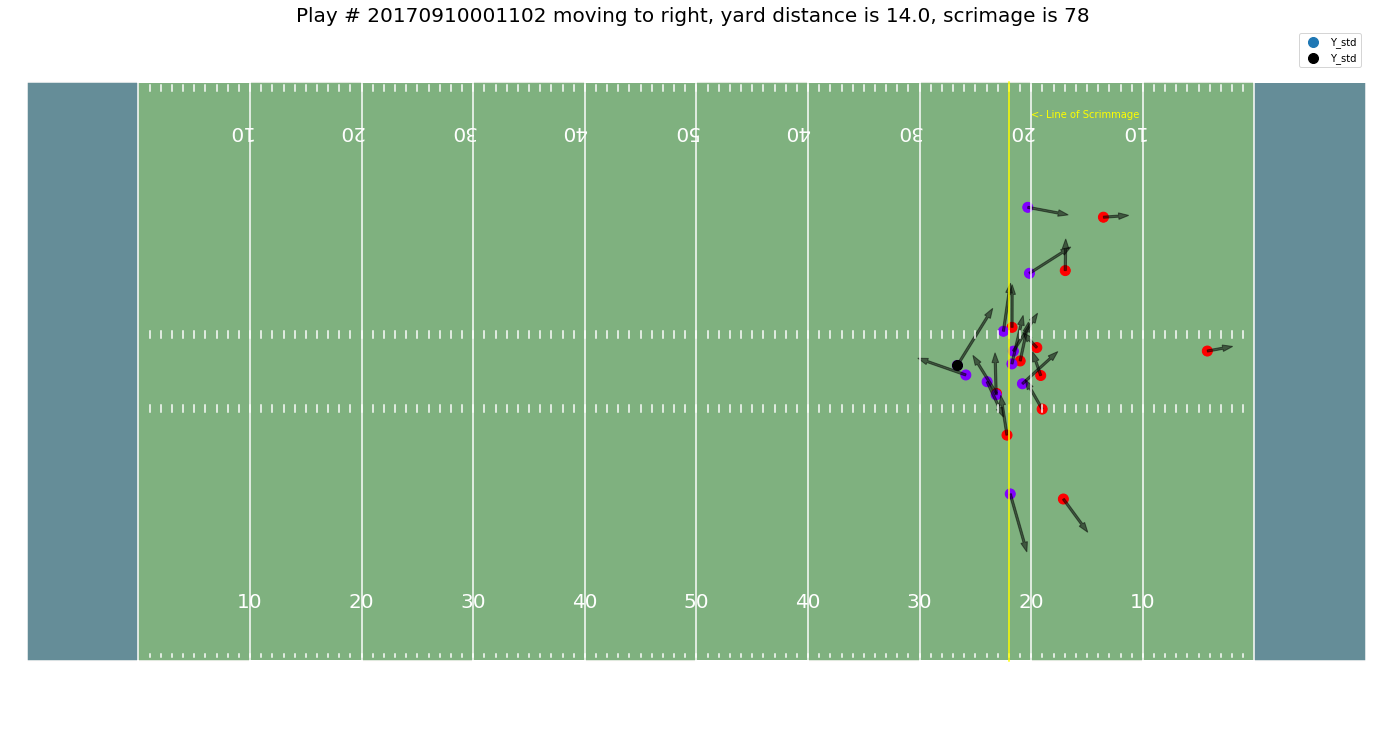

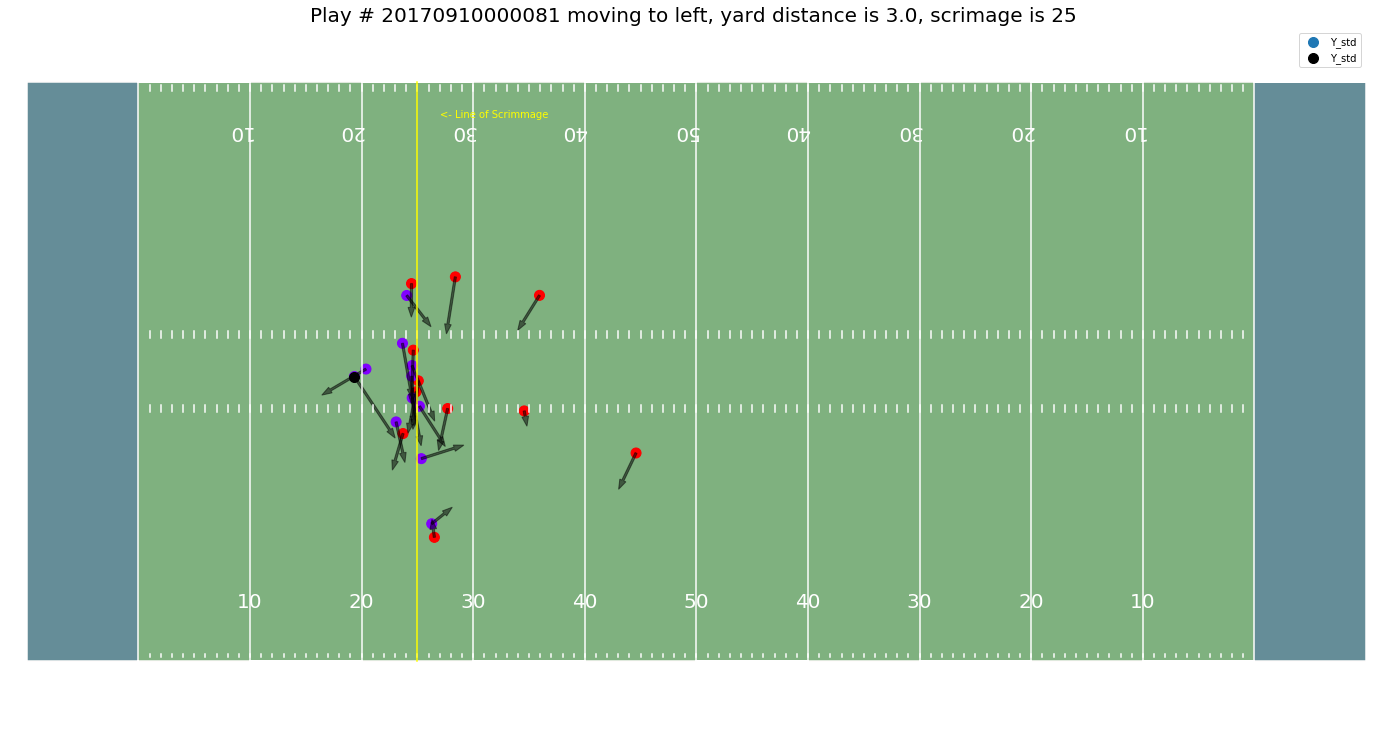

In [12]:
for play_id in [20170910001102, 20170910000081]: 
    show_play_std(play_id)

In the above plot, the blue team is always on offense, and the red team is always on defense. The blue team is also always moving left to right. The dotted line corresponds to where the play started -- if `Yards == 0`, that means that the ball carrier was tackled on or about the dotted line. If `Yards > 0`, the ball carrier ended the play to the right of the dotted line, and if `Yards < 0`, the ball carrier ended the play to the left of the dotted line.

Let's see how our standardised direction is distributed, for the offense teams, and for the defense teams.

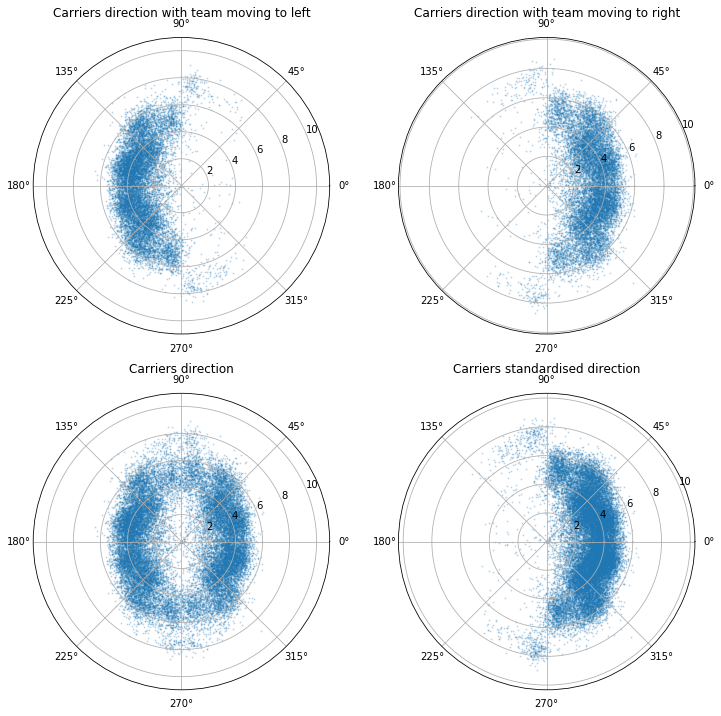

In [13]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(221, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier]
ax.set_title('Carriers direction with team moving to left')
ax.scatter(df.Dir_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(222, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier]
ax.set_title('Carriers direction with team moving to right')
ax.scatter(df.Dir_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(223, projection='polar')
df = train[train.IsOnOffense & train.IsBallCarrier]
ax.set_title('Carriers direction')
ax.scatter(df.Dir_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[train.IsOnOffense & train.IsBallCarrier]
ax.set_title('Carriers standardised direction')
ax.scatter(df.Dir_std, df.S, s=1, alpha=0.2)


We see that the standardized direction is centered around 0, which is to be expected.


Peter Hurford shared an interesting discovery in this notebook when he displayed orientation distribution by season: Peter Hurford 4:38 AM
https://www.kaggle.com/peterhurford/something-is-the-matter-with-orientation

Let's see what we got here.

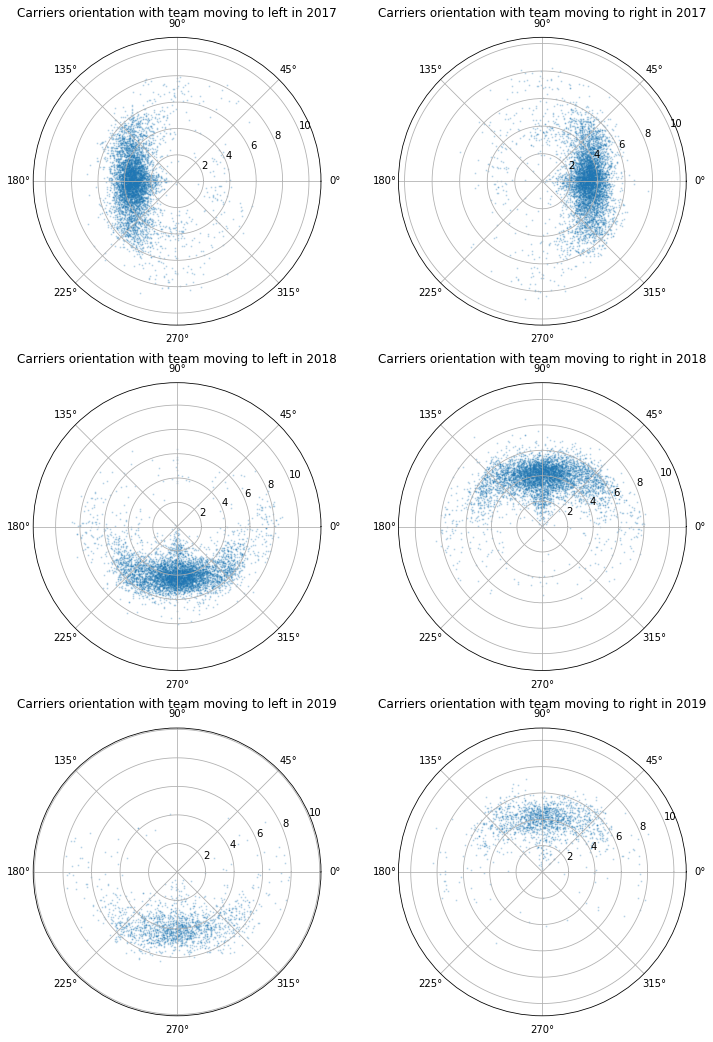

In [14]:
train['Orientation_rad'] = np.mod(train.Orientation, 360) * math.pi/180.0

plt.figure(figsize=(12, 18))
ax = plt.subplot(321, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2017)]
ax.set_title('Carriers orientation with team moving to left in 2017')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(322, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2017)]
ax.set_title('Carriers orientation with team moving to right in 2017')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(323, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2018)]
ax.set_title('Carriers orientation with team moving to left in 2018')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(324, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2018)]
ax.set_title('Carriers orientation with team moving to right in 2018')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)


ax = plt.subplot(325, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2019)]
ax.set_title('Carriers orientation with team moving to left in 2019')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(326, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2019)]
ax.set_title('Carriers orientation with team moving to right in 2019')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)


There is clearly a shift of 90 degrees from 2017 to 2018.

A possible fix is this.

In [15]:
train.loc[train.Season >= 2018, 'Orientation_rad'
         ] = np.mod(train.loc[train.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0


Let's check.

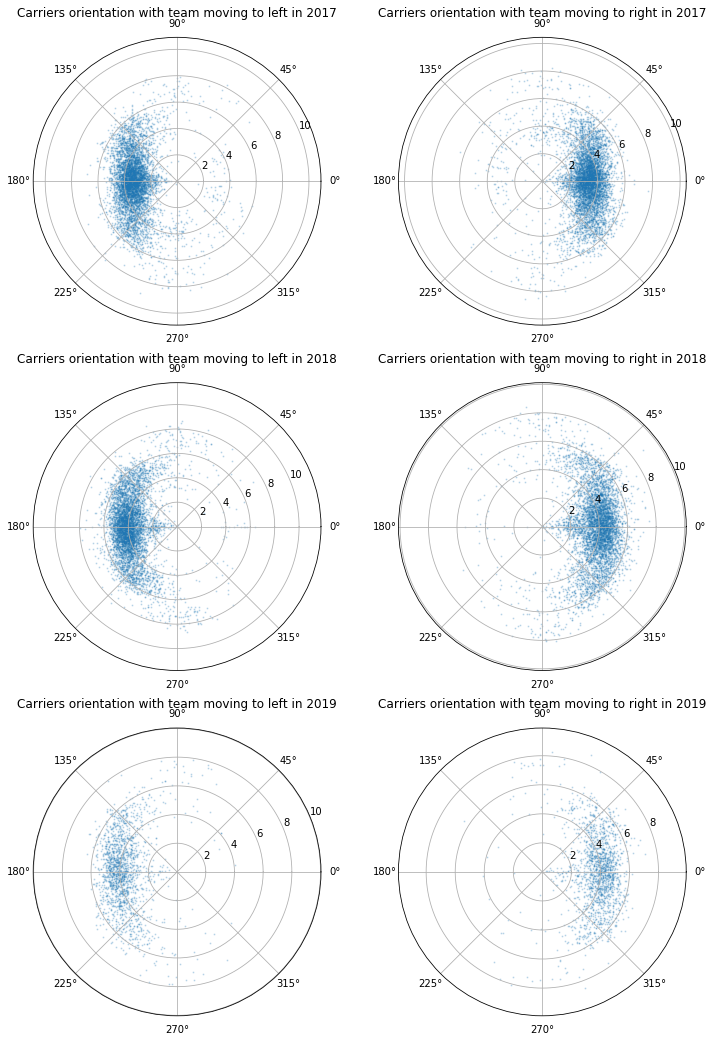

In [16]:
plt.figure(figsize=(12, 18))
ax = plt.subplot(321, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2017)]
ax.set_title('Carriers orientation with team moving to left in 2017')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(322, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2017)]
ax.set_title('Carriers orientation with team moving to right in 2017')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(323, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2018)]
ax.set_title('Carriers orientation with team moving to left in 2018')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(324, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2018)]
ax.set_title('Carriers orientation with team moving to right in 2018')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(325, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier & (train.Season == 2019)]
ax.set_title('Carriers orientation with team moving to left in 2019')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(326, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier & (train.Season == 2019)]
ax.set_title('Carriers orientation with team moving to right in 2019')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)


We can now standardise orientation as we did for direction.  Let's repeat all the code for clarity.

In [17]:
train['Orientation_rad'] = np.mod(train.Orientation, 360) * math.pi/180.0
train.loc[train.Season >= 2018, 'Orientation_rad'
         ] = np.mod(train.loc[train.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
train['Orientation_std'] = train.Orientation_rad
train.loc[train.ToLeft, 'Orientation_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Orientation_rad'], 2*np.pi)


Let's check

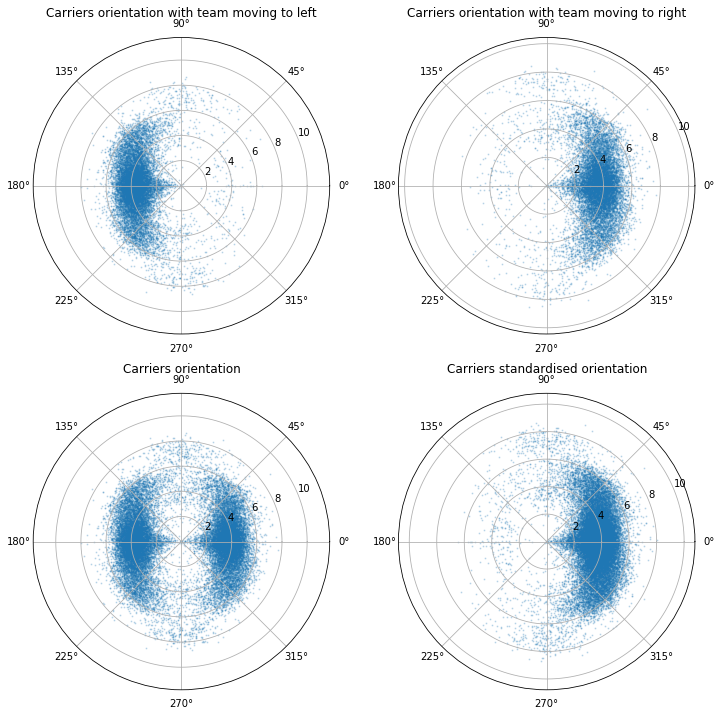

In [18]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(221, projection='polar')
df = train[train.ToLeft & train.IsBallCarrier]
ax.set_title('Carriers orientation with team moving to left')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(222, projection='polar')
df = train[~train.ToLeft & train.IsBallCarrier]
ax.set_title('Carriers orientation with team moving to right')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(223, projection='polar')
df = train[train.IsOnOffense & train.IsBallCarrier]
ax.set_title('Carriers orientation')
ax.scatter(df.Orientation_rad, df.S, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[train.IsOnOffense & train.IsBallCarrier]
ax.set_title('Carriers standardised orientation')
ax.scatter(df.Orientation_std, df.S, s=1, alpha=0.2)

Seems we are all set for orientation.

Let's now look at Voronoi diagram.  The code is straghtforward thanks to scipy.spatial package.

In [19]:
def show_voronoi(play_id, train=train):
    df = train[train.PlayId == play_id]
    xy = df[['X_std', 'Y_std']].values
    n_points = xy.shape[0]
    offense = df.IsOnOffense.values
    vor = Voronoi(xy)
    fig, ax = plt.subplots(1)
    ax.axis('equal')
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    for r in range(n_points):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            if offense[r]:
                plt.fill(*zip(*polygon), c='b', alpha=0.25)
            else:
                plt.fill(*zip(*polygon), c='r', alpha=0.25)
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=10)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)

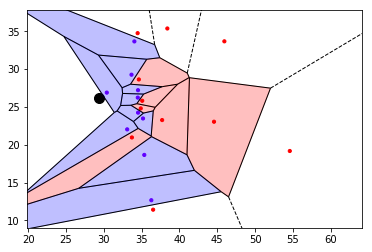

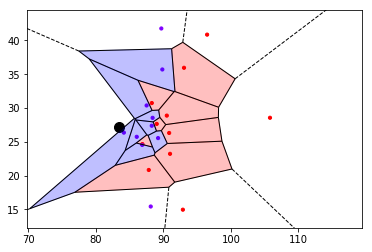

In [20]:
for play_id in [20170910000081, 20170910001102, ]: 
    vor = show_voronoi(play_id)

This looks nice but there are unbounded Voronoi regions.  One way to deal with it is to mirror points across field boundaries as suggested by [charlie_s](https://www.kaggle.com/charlessuhartanto) in his comment below.

In [21]:
def show_voronoi(play_id, train=train):
    df = train[train.PlayId == play_id]
    xy = df[['X_std', 'Y_std']].values
    n_points = xy.shape[0]
    xy1 = xy.copy()
    xy1[:,1] = - xy[:,1]
    xy2 = xy.copy()
    xy2[:,1] = 320/3 - xy[:,1]
    xy3 = xy.copy()
    xy3[:,0] = 20 - xy[:,0]
    xy4 = xy.copy()
    xy4[:,0] = 220 - xy[:,0]
    xy = np.concatenate((xy, xy1, xy2, xy3, xy4), axis=0)
    offense = df.IsOnOffense.values
    vor = Voronoi(xy)
    fig, ax = plt.subplots(1)
    ax.axis('equal')
    #voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    for r in range(n_points):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            if offense[r]:
                plt.fill(*zip(*polygon), c='b', alpha=0.25)
            else:
                plt.fill(*zip(*polygon), c='r', alpha=0.25)
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=10)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)

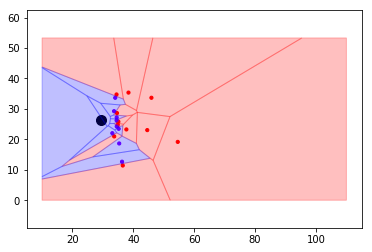

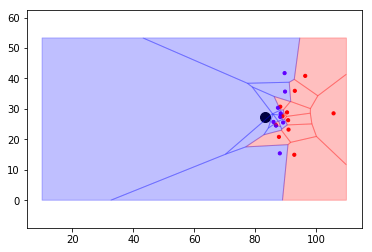

In [22]:
for play_id in [20170910000081, 20170910001102, ]: 
    vor = show_voronoi(play_id)

This looks better, doesn't it?

Here is a hint from Michael Lopez that I did not code (yet):

> Certainly, the area around the ball carrier (and perhaps the area around his teammates (the players in blue) will be related to the Yards gained. 


> Want a VIP hint? Consider a spatial diagram weights the area on the field by player speed. See [http://www.lukebornn.com/papers/fernandez_ssac_2018.pdf](http://www.lukebornn.com/papers/fernandez_ssac_2018.pdf) for one example in soccer, and last year's winning Big Data Bowl entry ([link](https://operations.nfl.com/media/3670/big-data-bowl-sfu.pdf)). 

Alternatively, the Voronoi diagram below removes all the players but the ball carrier (below). This allows the focus to be on the running back, as his teammates shouldn't exactly be counting against him. 

In [23]:
def show_voronoi_rusher(play_id, train=train):
    df = train[train.PlayId == play_id]
    df = df[(df.NflIdRusher == df.NflId) | ~df.IsOnOffense]
    xy = df[['X_std', 'Y_std']].values
    n_points = xy.shape[0]
    xy1 = xy.copy()
    xy1[:,1] = - xy[:,1]
    xy2 = xy.copy()
    xy2[:,1] = 320/3 - xy[:,1]
    xy3 = xy.copy()
    xy3[:,0] = 20 - xy[:,0]
    xy4 = xy.copy()
    xy4[:,0] = 220 - xy[:,0]
    xy = np.concatenate((xy, xy1, xy2, xy3, xy4), axis=0)
    offense = df.IsOnOffense.values
    vor = Voronoi(xy)
    fig, ax = plt.subplots(1)
    ax.axis('equal')
    for r in range(n_points):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            if offense[r]:
                plt.fill(*zip(*polygon), c='b', alpha=0.25)
            else:
                plt.fill(*zip(*polygon), c='r', alpha=0.25)
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=10)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)


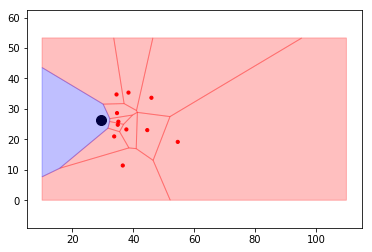

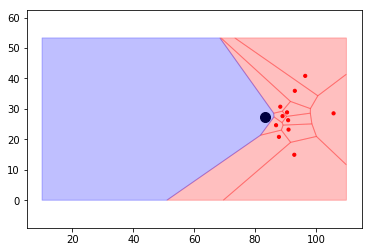

In [24]:
for play_id in [20170910000081, 20170910001102, ]: 
    vor = show_voronoi_rusher(play_id)